# ORF recognition by Convolutional/Recurrent

Test CNN+LSTM 16 on simulated RNA of length 64. 

Use restructured codebase from notebook 105.

In [15]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-21 18:36:25 UTC'

In [16]:
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=64            # how long is each sequence
CDS_LEN=32            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
CELLS = 16
NEURONS = 16
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=100  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [17]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [18]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [19]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 57 trials to reach 10 per class.
It took 102578 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [20]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 64.0
Average ORF length: 38.373636363636365
NC seqs
Average RNA length: 64.0
Average ORF length: 8.183909090909092


In [21]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [22]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [23]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(LSTM(CELLS,return_sequences=True))
    dnn.add(LSTM(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (64, 4)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 64, 16)            208       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 64, 16)            784       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 32, 16)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32, 16)            2112      
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_4 (Dropout)     

In [24]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (64, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 15s 9ms/step - loss: 0.6990 - accuracy: 0.5100 - val_loss: 0.6678 - val_accuracy: 0.5935


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.6578 - accuracy: 0.6119 - val_loss: 0.6167 - val_accuracy: 0.6492


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.6148 - accuracy: 0.6585 - val_loss: 0.5884 - val_accuracy: 0.6727


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.5904 - accuracy: 0.6804 - val_loss: 0.5758 - val_accuracy: 0.6836


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5768 - accuracy: 0.6883 - val_loss: 0.5697 - val_accuracy: 0.6853


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5673 - accuracy: 0.6934 - val_loss: 0.5630 - val_accuracy: 0.6904


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.5655 - accuracy: 0.6946 - val_loss: 0.5565 - val_accuracy: 0.6946


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5586 - accuracy: 0.7008 - val_loss: 0.5558 - val_accuracy: 0.6910
Epoch 9/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5580 - accuracy: 0.6989 - val_loss: 0.5598 - val_accuracy: 0.6887
Epoch 10/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5508 - accuracy: 0.7034 - val_loss: 0.5544 - val_accuracy: 0.6952


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5462 - accuracy: 0.7058 - val_loss: 0.5496 - val_accuracy: 0.6977


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 12/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5447 - accuracy: 0.7051 - val_loss: 0.5485 - val_accuracy: 0.6960
Epoch 13/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5423 - accuracy: 0.7058 - val_loss: 0.5497 - val_accuracy: 0.6977
Epoch 14/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.5390 - accuracy: 0.7107 - val_loss: 0.5554 - val_accuracy: 0.6911
Epoch 15/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5348 - accuracy: 0.7124 - val_loss: 0.5449 - val_accuracy: 0.6990


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 16/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5342 - accuracy: 0.7137 - val_loss: 0.5507 - val_accuracy: 0.7011


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5361 - accuracy: 0.7140 - val_loss: 0.5412 - val_accuracy: 0.7024


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.5317 - accuracy: 0.7139 - val_loss: 0.5441 - val_accuracy: 0.7000
Epoch 19/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5311 - accuracy: 0.7120 - val_loss: 0.5469 - val_accuracy: 0.7016
Epoch 20/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5273 - accuracy: 0.7165 - val_loss: 0.5501 - val_accuracy: 0.6969
Epoch 21/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5239 - accuracy: 0.7181 - val_loss: 0.5525 - val_accuracy: 0.6990
Epoch 22/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5249 - accuracy: 0.7175 - val_loss: 0.5553 - val_accuracy: 0.7001
Epoch 23/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5292 - accuracy: 0.7153 - val_loss: 0.5496 - val_accuracy: 0.6986
Epoch 24/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.5208 - accuracy: 0.7224 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 30/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5173 - accuracy: 0.7179 - val_loss: 0.5391 - val_accuracy: 0.7031


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 31/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5183 - accuracy: 0.7196 - val_loss: 0.5415 - val_accuracy: 0.7011
Epoch 32/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5154 - accuracy: 0.7221 - val_loss: 0.5575 - val_accuracy: 0.6946
Epoch 33/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5208 - accuracy: 0.7164 - val_loss: 0.5410 - val_accuracy: 0.7051


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 34/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5137 - accuracy: 0.7228 - val_loss: 0.5436 - val_accuracy: 0.7046
Epoch 35/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5078 - accuracy: 0.7297 - val_loss: 0.5508 - val_accuracy: 0.6982
Epoch 36/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5131 - accuracy: 0.7248 - val_loss: 0.5515 - val_accuracy: 0.7034
Epoch 37/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5090 - accuracy: 0.7279 - val_loss: 0.5440 - val_accuracy: 0.7045
Epoch 38/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5137 - accuracy: 0.7264 - val_loss: 0.5401 - val_accuracy: 0.7027
Epoch 39/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5066 - accuracy: 0.7310 - val_loss: 0.5440 - val_accuracy: 0.7003
Epoch 40/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5067 - accuracy: 0.7281 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 41/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5106 - accuracy: 0.7264 - val_loss: 0.5495 - val_accuracy: 0.7031
Epoch 42/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5074 - accuracy: 0.7279 - val_loss: 0.5422 - val_accuracy: 0.7067
Epoch 43/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5069 - accuracy: 0.7255 - val_loss: 0.5615 - val_accuracy: 0.6972
Epoch 44/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5161 - accuracy: 0.7261 - val_loss: 0.5534 - val_accuracy: 0.7059
Epoch 45/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4988 - accuracy: 0.7332 - val_loss: 0.5388 - val_accuracy: 0.7063
Epoch 46/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5053 - accuracy: 0.7296 - val_loss: 0.5386 - val_accuracy: 0.7059
Epoch 47/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.5007 - accuracy: 0.7367 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 52/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4950 - accuracy: 0.7366 - val_loss: 0.5372 - val_accuracy: 0.7079
Epoch 53/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5005 - accuracy: 0.7355 - val_loss: 0.5438 - val_accuracy: 0.7057
Epoch 54/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4989 - accuracy: 0.7357 - val_loss: 0.5407 - val_accuracy: 0.7077
Epoch 55/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.4982 - accuracy: 0.7361 - val_loss: 0.5484 - val_accuracy: 0.7108


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 56/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4918 - accuracy: 0.7368 - val_loss: 0.5502 - val_accuracy: 0.7082
Epoch 57/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4970 - accuracy: 0.7371 - val_loss: 0.5406 - val_accuracy: 0.7085
Epoch 58/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4875 - accuracy: 0.7411 - val_loss: 0.5647 - val_accuracy: 0.6951
Epoch 59/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.5094 - accuracy: 0.7301 - val_loss: 0.5406 - val_accuracy: 0.7027
Epoch 60/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4976 - accuracy: 0.7337 - val_loss: 0.5443 - val_accuracy: 0.7072
Epoch 61/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.4937 - accuracy: 0.7396 - val_loss: 0.5465 - val_accuracy: 0.7075
Epoch 62/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4878 - accuracy: 0.7410 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 74/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.4855 - accuracy: 0.7411 - val_loss: 0.5508 - val_accuracy: 0.7078
Epoch 75/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.4827 - accuracy: 0.7441 - val_loss: 0.5516 - val_accuracy: 0.7081
Epoch 76/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4825 - accuracy: 0.7437 - val_loss: 0.5626 - val_accuracy: 0.7077
Epoch 77/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4924 - accuracy: 0.7376 - val_loss: 0.5575 - val_accuracy: 0.7038
Epoch 78/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4914 - accuracy: 0.7368 - val_loss: 0.5569 - val_accuracy: 0.7094
Epoch 79/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4805 - accuracy: 0.7443 - val_loss: 0.5520 - val_accuracy: 0.7116


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 80/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4807 - accuracy: 0.7463 - val_loss: 0.5543 - val_accuracy: 0.7115
Epoch 81/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4779 - accuracy: 0.7465 - val_loss: 0.5527 - val_accuracy: 0.7087
Epoch 82/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4826 - accuracy: 0.7430 - val_loss: 0.5537 - val_accuracy: 0.7066
Epoch 83/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.4851 - accuracy: 0.7392 - val_loss: 0.5557 - val_accuracy: 0.7106
Epoch 84/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4768 - accuracy: 0.7488 - val_loss: 0.5554 - val_accuracy: 0.7081
Epoch 85/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4763 - accuracy: 0.7475 - val_loss: 0.5570 - val_accuracy: 0.7098
Epoch 86/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4798 - accuracy: 0.7480 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 89/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4828 - accuracy: 0.7445 - val_loss: 0.5539 - val_accuracy: 0.7110
Epoch 90/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4757 - accuracy: 0.7471 - val_loss: 0.5491 - val_accuracy: 0.7122


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 91/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4688 - accuracy: 0.7538 - val_loss: 0.5608 - val_accuracy: 0.7137


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 92/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4706 - accuracy: 0.7505 - val_loss: 0.5603 - val_accuracy: 0.7076
Epoch 93/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4735 - accuracy: 0.7457 - val_loss: 0.5597 - val_accuracy: 0.7132
Epoch 94/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.4745 - accuracy: 0.7499 - val_loss: 0.5600 - val_accuracy: 0.7106
Epoch 95/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4733 - accuracy: 0.7496 - val_loss: 0.5635 - val_accuracy: 0.7096
Epoch 96/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4692 - accuracy: 0.7517 - val_loss: 0.5597 - val_accuracy: 0.7097
Epoch 97/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4727 - accuracy: 0.7491 - val_loss: 0.5583 - val_accuracy: 0.7156


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 98/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4710 - accuracy: 0.7503 - val_loss: 0.5520 - val_accuracy: 0.7130
Epoch 99/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4734 - accuracy: 0.7456 - val_loss: 0.5486 - val_accuracy: 0.7105
Epoch 100/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4723 - accuracy: 0.7480 - val_loss: 0.5620 - val_accuracy: 0.7137
Fold 1, 100 epochs, 1355 sec


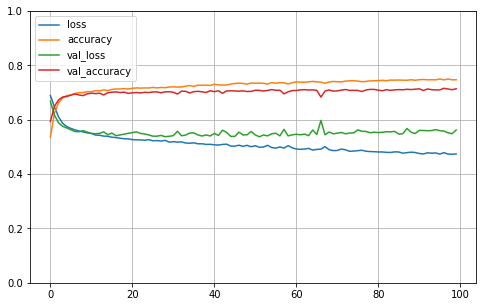

MODEL
make_DNN
input shape: (64, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 16s 9ms/step - loss: 0.7166 - accuracy: 0.5016 - val_loss: 0.6732 - val_accuracy: 0.5884
Epoch 2/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6705 - accuracy: 0.5898 - val_loss: 0.6358 - val_accuracy: 0.6391
Epoch 3/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6374 - accuracy: 0.6365 - val_loss: 0.6103 - val_accuracy: 0.6688
Epoch 4/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6071 - accuracy: 0.6682 - val_loss: 0.5868 - val_accuracy: 0.6755
Epoch 5/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5914 - accuracy: 0.6745 - val_loss: 0.5772 - val_accuracy: 0.6773
Epoch 6/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5803 - accuracy: 0.6841 - val_loss: 0.5661 - val_accuracy: 0.6916
Epoch 7/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5708

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 29/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5174 - accuracy: 0.7238 - val_loss: 0.5384 - val_accuracy: 0.7056
Epoch 30/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5195 - accuracy: 0.7189 - val_loss: 0.5367 - val_accuracy: 0.7158
Epoch 31/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5172 - accuracy: 0.7233 - val_loss: 0.5349 - val_accuracy: 0.7159
Epoch 32/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5147 - accuracy: 0.7216 - val_loss: 0.5284 - val_accuracy: 0.7158
Epoch 33/100
1334/1334 [==============================] - 11s 8ms/step - loss: 0.5181 - accuracy: 0.7228 - val_loss: 0.5437 - val_accuracy: 0.7114
Epoch 34/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5160 - accuracy: 0.7228 - val_loss: 0.5272 - val_accuracy: 0.7136
Epoch 35/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5179 - accuracy: 0.7170 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 38/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5121 - accuracy: 0.7235 - val_loss: 0.5330 - val_accuracy: 0.7134
Epoch 39/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5049 - accuracy: 0.7329 - val_loss: 0.5338 - val_accuracy: 0.7157
Epoch 40/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5079 - accuracy: 0.7274 - val_loss: 0.5297 - val_accuracy: 0.7159
Epoch 41/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5084 - accuracy: 0.7256 - val_loss: 0.5487 - val_accuracy: 0.7023
Epoch 42/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5037 - accuracy: 0.7263 - val_loss: 0.5301 - val_accuracy: 0.7177


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 43/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5011 - accuracy: 0.7309 - val_loss: 0.5510 - val_accuracy: 0.7123
Epoch 44/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5045 - accuracy: 0.7292 - val_loss: 0.5281 - val_accuracy: 0.7188


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 45/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5001 - accuracy: 0.7338 - val_loss: 0.5332 - val_accuracy: 0.7128
Epoch 46/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4992 - accuracy: 0.7335 - val_loss: 0.5383 - val_accuracy: 0.7170
Epoch 47/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4926 - accuracy: 0.7354 - val_loss: 0.5409 - val_accuracy: 0.7154
Epoch 48/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4928 - accuracy: 0.7383 - val_loss: 0.5324 - val_accuracy: 0.7172
Epoch 49/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4950 - accuracy: 0.7331 - val_loss: 0.5474 - val_accuracy: 0.7163
Epoch 50/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4920 - accuracy: 0.7352 - val_loss: 0.5383 - val_accuracy: 0.7135
Epoch 51/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5011 - accuracy: 0.7348 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 53/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4870 - accuracy: 0.7401 - val_loss: 0.5390 - val_accuracy: 0.7172
Epoch 54/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4873 - accuracy: 0.7399 - val_loss: 0.5346 - val_accuracy: 0.7233


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 55/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4848 - accuracy: 0.7451 - val_loss: 0.5356 - val_accuracy: 0.7203
Epoch 56/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4902 - accuracy: 0.7404 - val_loss: 0.5559 - val_accuracy: 0.7059
Epoch 57/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4914 - accuracy: 0.7377 - val_loss: 0.5408 - val_accuracy: 0.7205
Epoch 58/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4819 - accuracy: 0.7439 - val_loss: 0.5343 - val_accuracy: 0.7172
Epoch 59/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4837 - accuracy: 0.7435 - val_loss: 0.5235 - val_accuracy: 0.7278


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 60/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4841 - accuracy: 0.7386 - val_loss: 0.5254 - val_accuracy: 0.7197
Epoch 61/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4816 - accuracy: 0.7444 - val_loss: 0.5258 - val_accuracy: 0.7232
Epoch 62/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4907 - accuracy: 0.7425 - val_loss: 0.5302 - val_accuracy: 0.7169
Epoch 63/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.5120 - accuracy: 0.7255 - val_loss: 0.5231 - val_accuracy: 0.7232
Epoch 64/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4831 - accuracy: 0.7441 - val_loss: 0.5216 - val_accuracy: 0.7231
Epoch 65/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4808 - accuracy: 0.7436 - val_loss: 0.5161 - val_accuracy: 0.7295


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 66/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4761 - accuracy: 0.7456 - val_loss: 0.5245 - val_accuracy: 0.7277
Epoch 67/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4760 - accuracy: 0.7461 - val_loss: 0.5174 - val_accuracy: 0.7289
Epoch 68/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4831 - accuracy: 0.7455 - val_loss: 0.5201 - val_accuracy: 0.7262
Epoch 69/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4730 - accuracy: 0.7482 - val_loss: 0.5171 - val_accuracy: 0.7309


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 70/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4665 - accuracy: 0.7569 - val_loss: 0.5233 - val_accuracy: 0.7354


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 71/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4705 - accuracy: 0.7523 - val_loss: 0.5173 - val_accuracy: 0.7350
Epoch 72/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4661 - accuracy: 0.7570 - val_loss: 0.5164 - val_accuracy: 0.7343
Epoch 73/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4583 - accuracy: 0.7628 - val_loss: 0.5147 - val_accuracy: 0.7361


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 74/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4590 - accuracy: 0.7598 - val_loss: 0.5281 - val_accuracy: 0.7305
Epoch 75/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4591 - accuracy: 0.7600 - val_loss: 0.5145 - val_accuracy: 0.7376


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 76/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4701 - accuracy: 0.7562 - val_loss: 0.5101 - val_accuracy: 0.7382


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 77/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4746 - accuracy: 0.7534 - val_loss: 0.5157 - val_accuracy: 0.7374
Epoch 78/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4843 - accuracy: 0.7482 - val_loss: 0.5052 - val_accuracy: 0.7411


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 79/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4584 - accuracy: 0.7644 - val_loss: 0.4949 - val_accuracy: 0.7456


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 80/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4537 - accuracy: 0.7651 - val_loss: 0.4984 - val_accuracy: 0.7464


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 81/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4871 - accuracy: 0.7479 - val_loss: 0.5080 - val_accuracy: 0.7376
Epoch 82/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4598 - accuracy: 0.7639 - val_loss: 0.4948 - val_accuracy: 0.7474


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 83/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4446 - accuracy: 0.7757 - val_loss: 0.5088 - val_accuracy: 0.7438
Epoch 84/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4494 - accuracy: 0.7684 - val_loss: 0.5062 - val_accuracy: 0.7452
Epoch 85/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4429 - accuracy: 0.7737 - val_loss: 0.4857 - val_accuracy: 0.7539


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 86/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4491 - accuracy: 0.7666 - val_loss: 0.4843 - val_accuracy: 0.7577


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 87/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4438 - accuracy: 0.7704 - val_loss: 0.4937 - val_accuracy: 0.7522
Epoch 88/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4598 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy: 0.7014
Epoch 89/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4901 - accuracy: 0.7456 - val_loss: 0.4809 - val_accuracy: 0.7577
Epoch 90/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4498 - accuracy: 0.7698 - val_loss: 0.4861 - val_accuracy: 0.7530
Epoch 91/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4438 - accuracy: 0.7785 - val_loss: 0.4841 - val_accuracy: 0.7524
Epoch 92/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4421 - accuracy: 0.7752 - val_loss: 0.4777 - val_accuracy: 0.7647


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 93/100
1334/1334 [==============================] - 11s 9ms/step - loss: 0.4372 - accuracy: 0.7763 - val_loss: 0.4828 - val_accuracy: 0.7624
Epoch 94/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4296 - accuracy: 0.7821 - val_loss: 0.4745 - val_accuracy: 0.7676


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 95/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4246 - accuracy: 0.7847 - val_loss: 0.4631 - val_accuracy: 0.7704


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 96/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4256 - accuracy: 0.7846 - val_loss: 0.4694 - val_accuracy: 0.7645
Epoch 97/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4241 - accuracy: 0.7876 - val_loss: 0.4809 - val_accuracy: 0.7595
Epoch 98/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4329 - accuracy: 0.7863 - val_loss: 0.4540 - val_accuracy: 0.7731


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 99/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4160 - accuracy: 0.7924 - val_loss: 0.4543 - val_accuracy: 0.7727
Epoch 100/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4654 - accuracy: 0.7615 - val_loss: 0.4549 - val_accuracy: 0.7737


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Fold 2, 100 epochs, 1375 sec


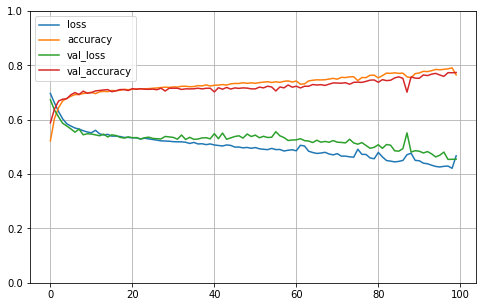

MODEL
make_DNN
input shape: (64, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 17s 10ms/step - loss: 0.7154 - accuracy: 0.5005 - val_loss: 0.6905 - val_accuracy: 0.4988
Epoch 2/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6859 - accuracy: 0.5481 - val_loss: 0.6508 - val_accuracy: 0.6207
Epoch 3/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6479 - accuracy: 0.6255 - val_loss: 0.6309 - val_accuracy: 0.6318
Epoch 4/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6304 - accuracy: 0.6381 - val_loss: 0.6252 - val_accuracy: 0.6356
Epoch 5/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6241 - accuracy: 0.6469 - val_loss: 0.6205 - val_accuracy: 0.6422
Epoch 6/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6210 - accuracy: 0.6476 - val_loss: 0.6185 - val_accuracy: 0.6479
Epoch 7/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.609

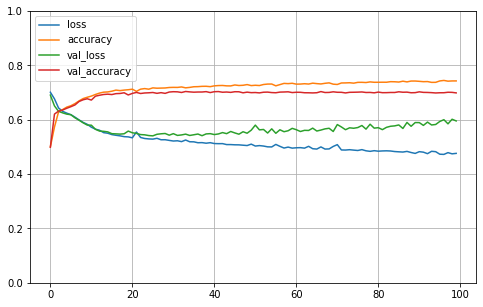

In [25]:
do_cross_validation(X,y)

In [26]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 76.45%


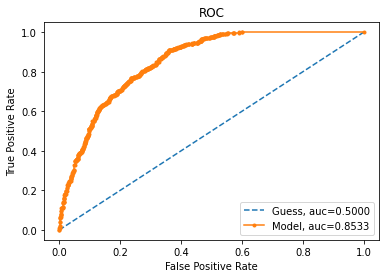

AUC: 85.33%


In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [28]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-21 19:42:24 UTC'